<a href="https://colab.research.google.com/github/Fh-19/Multi_Channel_Signal_Viewer/blob/main/doppler_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Drive and install deps (run once)
from google.colab import drive
drive.mount('/content/drive')

!pip install -q librosa torch torchvision torchaudio matplotlib numpy pandas tqdm scikit-learn soundfile


Mounted at /content/drive


In [ ]:
import os, re, random
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix


In [ ]:
# Update this path to your folder in Drive
DATA_DIR = "/content/drive/MyDrive/car_sounds"

def parse_label_from_filename(fname):
    # expects car_<speed>kmh_<freq>Hz_xxx.wav
    m = re.search(r'car_(\d+(?:\.\d+)?)kmh_(\d+(?:\.\d+)?)Hz', os.path.basename(fname))
    if not m:
        raise ValueError(f"Filename not in expected format: {fname}")
    return float(m.group(1)), float(m.group(2))

# collect files
all_files = sorted([os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.lower().endswith('.wav')])
print("Total files found:", len(all_files))
if len(all_files) == 0:
    raise RuntimeError("No wav files found in DATA_DIR")

# build labels array for normalization
labels = np.array([parse_label_from_filename(f) for f in all_files])  # shape (N,2)
target_mean = labels.mean(axis=0)
target_std = labels.std(axis=0) + 1e-8
print("Target mean (speed, freq):", target_mean)
print("Target std  (speed, freq):", target_std)


Total files found: 480
Target mean (speed, freq): [ 70. 450.]
Target std  (speed, freq): [ 28.28427126 170.78251278]


In [ ]:
class CarSoundDataset(Dataset):
    def __init__(self, files, sr=22050, n_mels=64, max_frames=400, augment=False, mean=None, std=None):
        self.files = files
        self.sr = sr
        self.n_mels = n_mels
        self.max_frames = max_frames
        self.augment = augment
        self.mean = np.array(mean) if mean is not None else np.array([0.0, 0.0])
        self.std = np.array(std) if std is not None else np.array([1.0, 1.0])

    def __len__(self):
        return len(self.files)

    def _augment(self, y):
        # small augmentations to increase variability
        # pitch shift +/- 1 semitone, or time-stretch 0.95-1.05
        if random.random() < 0.3:
            n_steps = random.uniform(-1.0, 1.0)
            y = librosa.effects.pitch_shift(y, sr=self.sr, n_steps=n_steps)
        if random.random() < 0.3:
            rate = random.uniform(0.95, 1.05)
            try:
                y = librosa.effects.time_stretch(y, rate)
            except Exception:
                pass
        # small gaussian noise
        if random.random() < 0.2:
            y = y + 0.001*np.random.randn(len(y))
        return y

    def __getitem__(self, idx):
        path = self.files[idx]
        y, sr = librosa.load(path, sr=self.sr)
        if self.augment:
            y = self._augment(y)

        # mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-9)

        # pad or trim along time axis
        if mel_db.shape[1] < self.max_frames:
            pad = self.max_frames - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0,0),(0,pad)), mode='constant', constant_values=0.0)
        else:
            mel_db = mel_db[:, :self.max_frames]

        # labels
        speed, freq = parse_label_from_filename(path)
        label = np.array([speed, freq], dtype=np.float32)
        label_norm = (label - self.mean) / self.std

        mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0)  # (1, n_mels, max_frames)
        label_tensor = torch.tensor(label_norm, dtype=torch.float32)

        return mel_tensor, label_tensor, os.path.basename(path)


In [ ]:
# split
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

# dataset params - you can increase max_frames if audio is long (but memory grows)
ds_kwargs = {
    "sr": 22050,
    "n_mels": 64,
    "max_frames": 400,
    "mean": target_mean,
    "std": target_std
}

train_dataset = CarSoundDataset(train_files, augment=True, **ds_kwargs)
test_dataset  = CarSoundDataset(test_files, augment=False, **ds_kwargs)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 384 Test size: 96


In [ ]:
class DopplerNet(nn.Module):
    def __init__(self):
        super(DopplerNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4,4))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 2)  # speed_norm, freq_norm
        )
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DopplerNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for mel, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        mel = mel.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * mel.size(0)

    avg_loss = epoch_loss / len(train_dataset)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")


Epoch 1/50: 100%|██████████| 24/24 [01:05<00:00,  2.71s/it]


Epoch 1/50 - Loss: 0.6433


Epoch 2/50: 100%|██████████| 24/24 [00:26<00:00,  1.08s/it]


Epoch 2/50 - Loss: 0.3314


Epoch 3/50: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


Epoch 3/50 - Loss: 0.2360


Epoch 4/50: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Epoch 4/50 - Loss: 0.1959


Epoch 5/50: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]


Epoch 5/50 - Loss: 0.1723


Epoch 6/50: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Epoch 6/50 - Loss: 0.1615


Epoch 7/50: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Epoch 7/50 - Loss: 0.1484


Epoch 8/50: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Epoch 8/50 - Loss: 0.1227


Epoch 9/50: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Epoch 9/50 - Loss: 0.1124


Epoch 10/50: 100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


Epoch 10/50 - Loss: 0.1378


Epoch 11/50: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Epoch 11/50 - Loss: 0.1199


Epoch 12/50: 100%|██████████| 24/24 [00:20<00:00,  1.14it/s]


Epoch 12/50 - Loss: 0.1228


Epoch 13/50: 100%|██████████| 24/24 [00:22<00:00,  1.06it/s]


Epoch 13/50 - Loss: 0.1052


Epoch 14/50: 100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


Epoch 14/50 - Loss: 0.1249


Epoch 15/50: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


Epoch 15/50 - Loss: 0.1206


Epoch 16/50: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 16/50 - Loss: 0.1205


Epoch 17/50: 100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


Epoch 17/50 - Loss: 0.1138


Epoch 18/50: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


Epoch 18/50 - Loss: 0.1052


Epoch 19/50: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]


Epoch 19/50 - Loss: 0.0941


Epoch 20/50: 100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


Epoch 20/50 - Loss: 0.0824


Epoch 21/50: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Epoch 21/50 - Loss: 0.0971


Epoch 22/50: 100%|██████████| 24/24 [00:20<00:00,  1.14it/s]


Epoch 22/50 - Loss: 0.0856


Epoch 23/50: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Epoch 23/50 - Loss: 0.0931


Epoch 24/50: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Epoch 24/50 - Loss: 0.0873


Epoch 25/50: 100%|██████████| 24/24 [00:21<00:00,  1.09it/s]


Epoch 25/50 - Loss: 0.0682


Epoch 26/50: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Epoch 26/50 - Loss: 0.0670


Epoch 27/50: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 27/50 - Loss: 0.0620


Epoch 28/50: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


Epoch 28/50 - Loss: 0.0731


Epoch 29/50: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Epoch 29/50 - Loss: 0.0701


Epoch 30/50: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


Epoch 30/50 - Loss: 0.0664


Epoch 31/50: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Epoch 31/50 - Loss: 0.0615


Epoch 32/50: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


Epoch 32/50 - Loss: 0.0658


Epoch 33/50: 100%|██████████| 24/24 [00:21<00:00,  1.09it/s]


Epoch 33/50 - Loss: 0.0615


Epoch 34/50: 100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


Epoch 34/50 - Loss: 0.0654


Epoch 35/50: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


Epoch 35/50 - Loss: 0.0659


Epoch 36/50: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]


Epoch 36/50 - Loss: 0.0724


Epoch 37/50: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 37/50 - Loss: 0.0689


Epoch 38/50: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


Epoch 38/50 - Loss: 0.0696


Epoch 39/50: 100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


Epoch 39/50 - Loss: 0.0589


Epoch 40/50: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Epoch 40/50 - Loss: 0.0600


Epoch 41/50: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


Epoch 41/50 - Loss: 0.0656


Epoch 42/50: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 42/50 - Loss: 0.0697


Epoch 43/50: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


Epoch 43/50 - Loss: 0.0682


Epoch 44/50: 100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Epoch 44/50 - Loss: 0.0545


Epoch 45/50: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Epoch 45/50 - Loss: 0.0596


Epoch 46/50: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


Epoch 46/50 - Loss: 0.0543


Epoch 47/50: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]


Epoch 47/50 - Loss: 0.0630


Epoch 48/50: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


Epoch 48/50 - Loss: 0.0634


Epoch 49/50: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


Epoch 49/50 - Loss: 0.0604


Epoch 50/50: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Epoch 50/50 - Loss: 0.0618


In [ ]:
save_path = "/content/drive/MyDrive/doppler_model_regression.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'target_mean': target_mean,
    'target_std': target_std,
    'n_mels': ds_kwargs['n_mels'],
    'max_frames': ds_kwargs['max_frames']
}, save_path)
print("Model saved to", save_path)


Model saved to /content/drive/MyDrive/doppler_model_regression.pth


In [ ]:
# inference on test set and collect predictions
model.eval()
all_trues = []
all_preds = []
all_names = []

with torch.no_grad():
    for mel, labels_norm, names in tqdm(test_loader, desc="Evaluating"):
        mel = mel.to(device)
        out_norm = model(mel).cpu().numpy()
        labels_norm = labels_norm.numpy()
        # unnormalize
        preds = out_norm * target_std + target_mean
        trues = labels_norm * target_std + target_mean

        all_preds.append(preds)
        all_trues.append(trues)
        all_names.extend(names)

all_preds = np.vstack(all_preds)  # shape (M,2)
all_trues = np.vstack(all_trues)

# regression metrics
mae_speed = mean_absolute_error(all_trues[:,0], all_preds[:,0])
mae_freq  = mean_absolute_error(all_trues[:,1], all_preds[:,1])
rmse_speed = mean_squared_error(all_trues[:,0], all_preds[:,0])
rmse_freq  = mean_squared_error(all_trues[:,1], all_preds[:,1])
r2_speed = r2_score(all_trues[:,0], all_preds[:,0])
r2_freq  = r2_score(all_trues[:,1], all_preds[:,1])

print("Regression metrics:")
print(f" Speed  - MAE: {mae_speed:.3f} km/h, RMSE: {rmse_speed:.3f}, R2: {r2_speed:.3f}")
print(f" Freq   - MAE: {mae_freq:.3f} Hz, RMSE: {rmse_freq:.3f}, R2: {r2_freq:.3f}")

# Save CSV of results
df = pd.DataFrame({
    "filename": all_names,
    "true_speed": all_trues[:,0],
    "pred_speed": all_preds[:,0],
    "true_freq": all_trues[:,1],
    "pred_freq": all_preds[:,1]
})
csv_path = "/content/drive/MyDrive/doppler_predictions.csv"
df.to_csv(csv_path, index=False)
print("Saved predictions CSV to:", csv_path)


Evaluating: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Regression metrics:
 Speed  - MAE: 3.637 km/h, RMSE: 19.926, R2: 0.974
 Freq   - MAE: 7.331 Hz, RMSE: 85.390, R2: 0.997
Saved predictions CSV to: /content/drive/MyDrive/doppler_predictions.csv


In [ ]:
# PARAMETERS: number of bins to create for speed and frequency
speed_bins = 5
freq_bins  = 5

# create bins based on true values range (you could also set fixed bins)
speed_min, speed_max = all_trues[:,0].min(), all_trues[:,0].max()
freq_min, freq_max   = all_trues[:,1].min(), all_trues[:,1].max()

speed_edges = np.linspace(speed_min, speed_max, speed_bins+1)
freq_edges  = np.linspace(freq_min, freq_max, freq_bins+1)

# digitize: returns bin index in 1..bins, subtract 1 to get 0..bins-1
true_speed_bins = np.digitize(all_trues[:,0], speed_edges) - 1
pred_speed_bins = np.digitize(all_preds[:,0], speed_edges) - 1
true_freq_bins  = np.digitize(all_trues[:,1], freq_edges) - 1
pred_freq_bins  = np.digitize(all_preds[:,1], freq_edges) - 1

# clip indices to valid range
true_speed_bins = np.clip(true_speed_bins, 0, speed_bins-1)
pred_speed_bins = np.clip(pred_speed_bins, 0, speed_bins-1)
true_freq_bins  = np.clip(true_freq_bins, 0, freq_bins-1)
pred_freq_bins  = np.clip(pred_freq_bins, 0, freq_bins-1)

# compute metrics for speed bins
acc_speed = accuracy_score(true_speed_bins, pred_speed_bins)
prec_speed, recall_speed, f1_speed, _ = precision_recall_fscore_support(true_speed_bins, pred_speed_bins, average='weighted', zero_division=0)
cm_speed = confusion_matrix(true_speed_bins, pred_speed_bins)

print("\nBinned (classification-style) metrics — SPEED")
print(f" Accuracy: {acc_speed:.3f}")
print(f" Precision: {prec_speed:.3f}, Recall: {recall_speed:.3f}, F1: {f1_speed:.3}")
print("Confusion Matrix (rows=true bins, cols=pred bins):")
print(cm_speed)

# compute metrics for freq bins
acc_freq = accuracy_score(true_freq_bins, pred_freq_bins)
prec_freq, recall_freq, f1_freq, _ = precision_recall_fscore_support(true_freq_bins, pred_freq_bins, average='weighted', zero_division=0)
cm_freq = confusion_matrix(true_freq_bins, pred_freq_bins)

print("\nBinned (classification-style) metrics — FREQUENCY")
print(f" Accuracy: {acc_freq:.3f}")
print(f" Precision: {prec_speed:.3f}, Recall: {recall_speed:.3f}, F1: {f1_speed:.3f}")
print("Confusion Matrix (rows=true bins, cols=pred bins):")
print(cm_freq)



Binned (classification-style) metrics — SPEED
 Accuracy: 0.917
 Precision: 0.923, Recall: 0.917, F1: 0.915
Confusion Matrix (rows=true bins, cols=pred bins):
[[14  0  0  0  0]
 [ 3 12  0  0  0]
 [ 0  1 15  3  0]
 [ 0  0  0 22  1]
 [ 0  0  0  0 25]]

Binned (classification-style) metrics — FREQUENCY
 Accuracy: 0.792
 Precision: 0.923, Recall: 0.917, F1: 0.915
Confusion Matrix (rows=true bins, cols=pred bins):
[[14  0  0  0  0]
 [ 7 24  2  0  0]
 [ 0  0  0  0  0]
 [ 0  0  9 22  2]
 [ 0  0  0  0 16]]


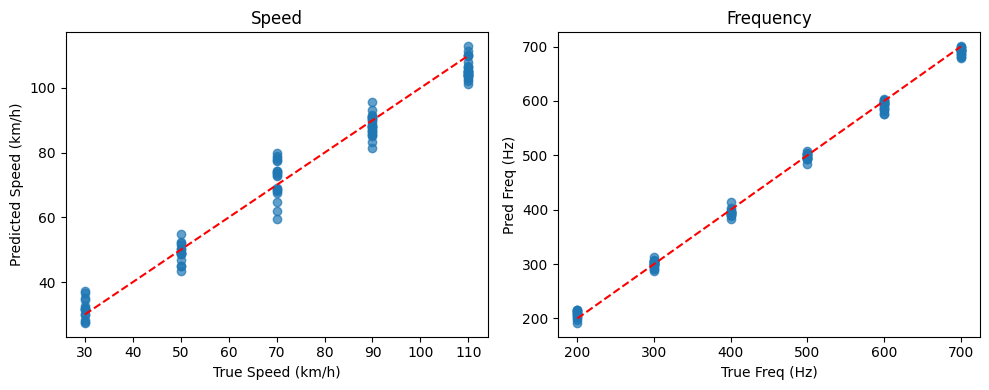

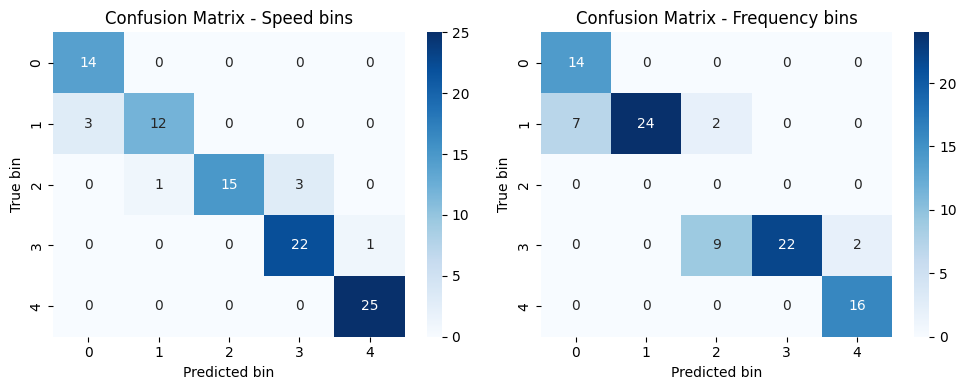

In [ ]:
import seaborn as sns
# scatter predictions vs true
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(all_trues[:,0], all_preds[:,0], alpha=0.7)
plt.plot([all_trues[:,0].min(), all_trues[:,0].max()], [all_trues[:,0].min(), all_trues[:,0].max()], 'r--')
plt.xlabel("True Speed (km/h)"); plt.ylabel("Predicted Speed (km/h)"); plt.title("Speed")

plt.subplot(1,2,2)
plt.scatter(all_trues[:,1], all_preds[:,1], alpha=0.7)
plt.plot([all_trues[:,1].min(), all_trues[:,1].max()], [all_trues[:,1].min(), all_trues[:,1].max()], 'r--')
plt.xlabel("True Freq (Hz)"); plt.ylabel("Pred Freq (Hz)"); plt.title("Frequency")
plt.tight_layout()
plt.show()

# confusion matrices heatmaps
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(cm_speed, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Speed bins")
plt.xlabel("Predicted bin"); plt.ylabel("True bin")

plt.subplot(1,2,2)
sns.heatmap(cm_freq, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Frequency bins")
plt.xlabel("Predicted bin"); plt.ylabel("True bin")
plt.tight_layout()
plt.show()
